In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.signal import argrelextrema

FPS = 24.

In [3]:
def normalizeRGB(x):
    r, g, b = x[:,0], x[:,1], x[:,2]
    r = (r - r.mean()) / r.std()
    g = (g - g.mean()) / g.std()
    b = (b - b.mean()) / b.std()
    return np.array([r, g, b])

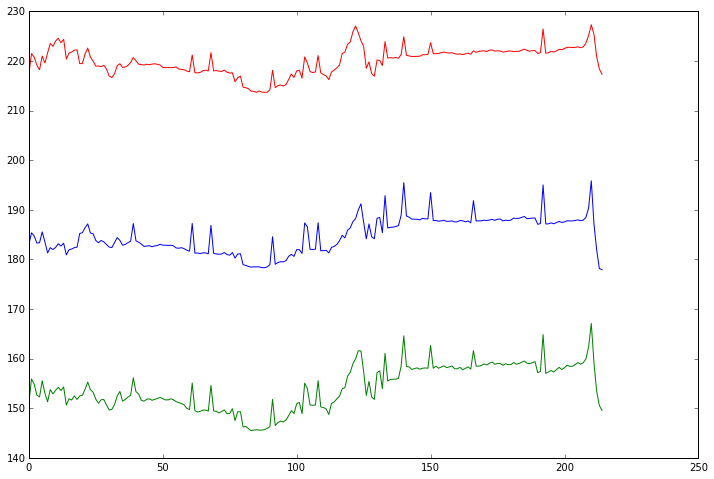

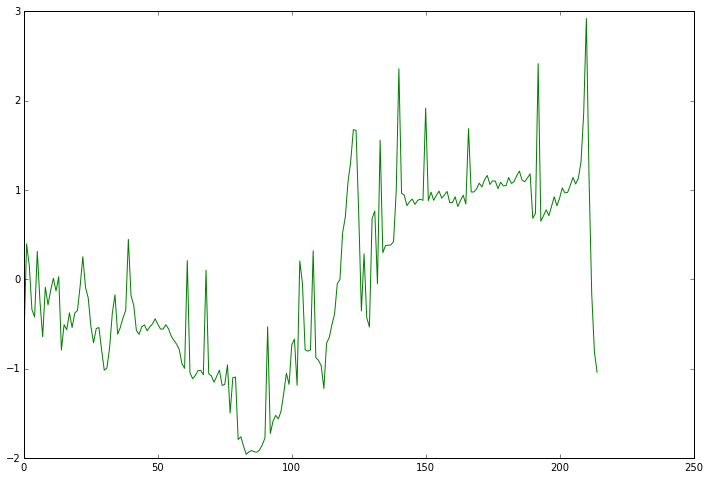

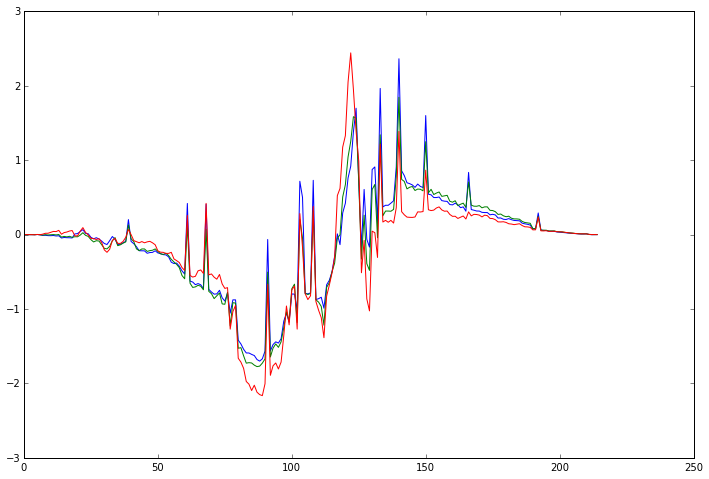

In [9]:
x = np.loadtxt("data/me.txt")


x = x[:1500]
t = np.linspace(0, len(x)/FPS, len(x))
plt.figure(figsize=(12,8))
plt.plot(x)
plt.show()

plt.figure(figsize=(12,8))
x = normalizeRGB(x)

r,g,b = x
plt.plot(g, c='g');
plt.show()

x_hann = x *  np.hanning(x.shape[1])
r2, g2, b2 = x_hann
plt.figure(figsize=(12,8))
plt.plot(zip(r2,g2,b2));




In [20]:
x.shape

(3, 931)

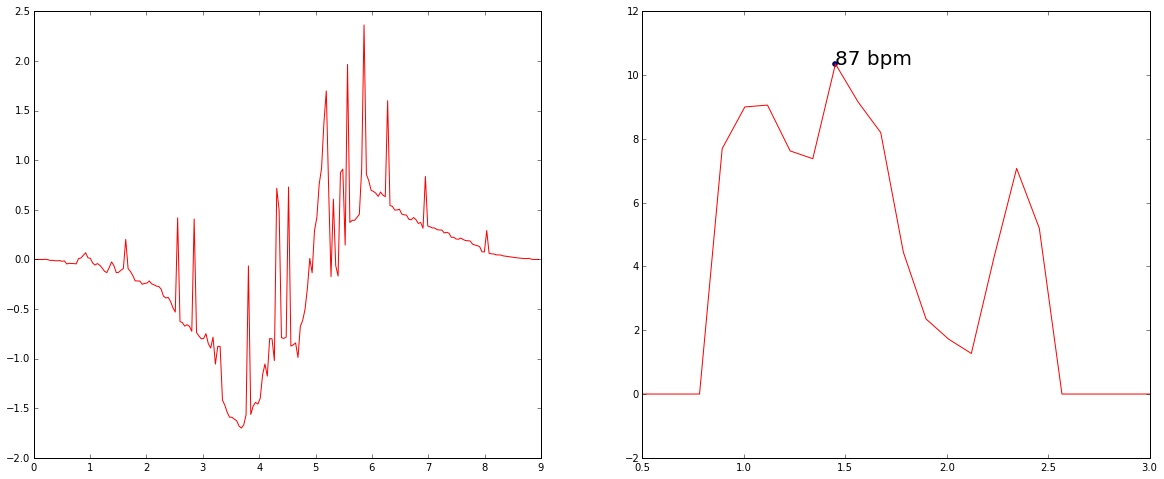

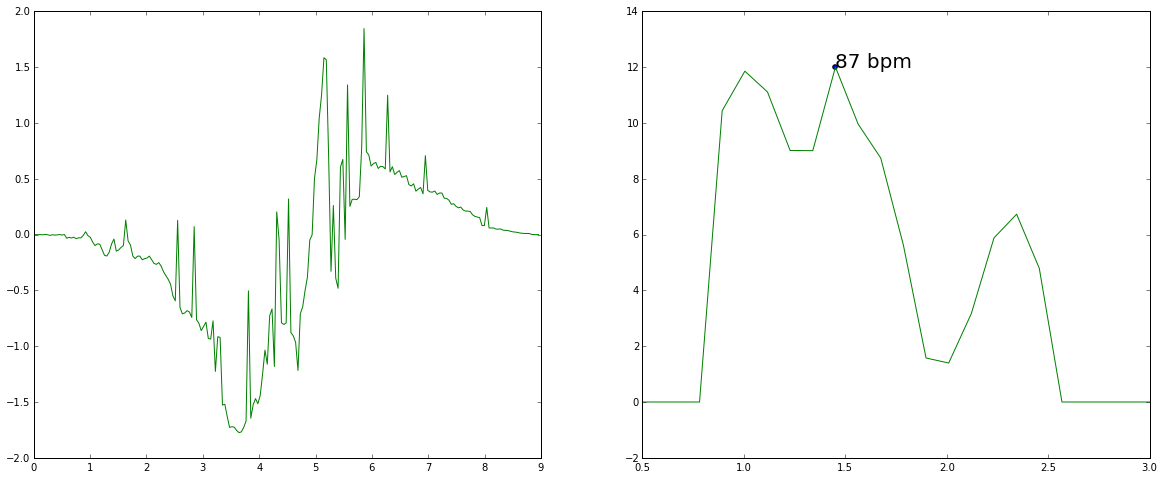

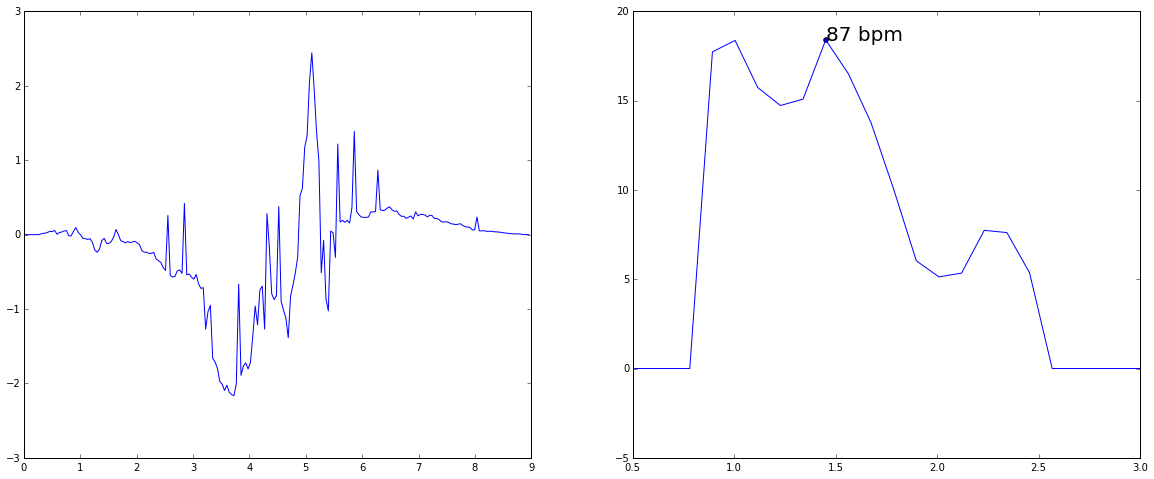

In [10]:
for cs, color in zip(['r','g','b'], [r2,g2,b2]):
    #Smooth the signal
#     window_size = 5
#     window = np.ones(int(window_size))/float(window_size)
#     color = np.convolve(color, window, 'same')
    
    n = len(color)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    ax1.plot(t, color, c=cs)
    
    # Fourier transform
    I = abs(np.fft.fft(color)[:n/2])
    freqs = np.fft.fftfreq(n, 1./FPS)[:n/2]
    
    
    #Filter
    I[(freqs<.8) | (freqs>2.5)] = 0
    
    max_f = freqs[I.argmax()]
    ax2.scatter(max_f, I.max())
    
    
    ax2.annotate(s="%.0f bpm"%(max_f*60), xy=(max_f, I.max()), size=20)

    #Fourier transform
    ax2.plot(freqs, I, c=cs)
    ax2.set_xlim(.5, 3.0)
    
    
    plt.show()

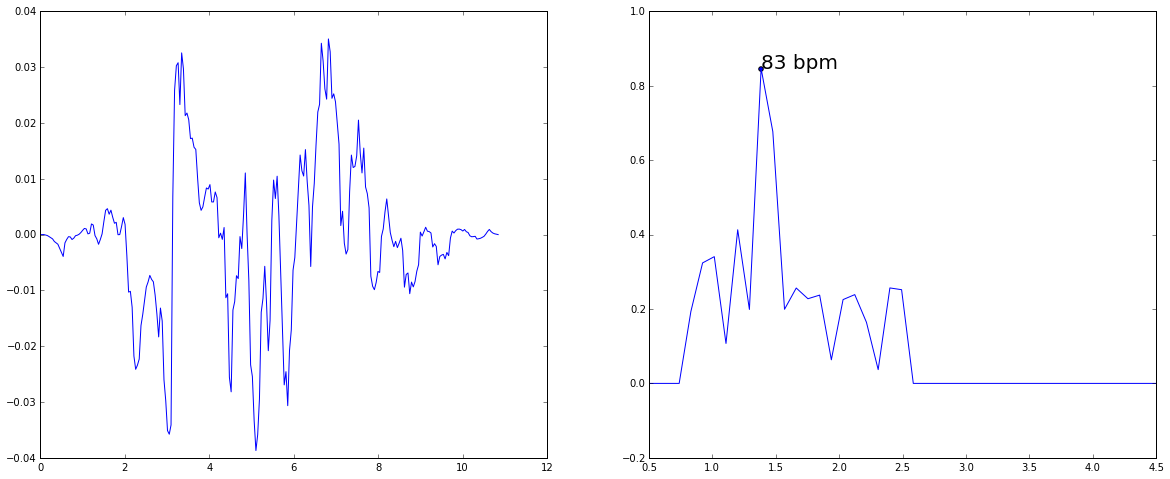

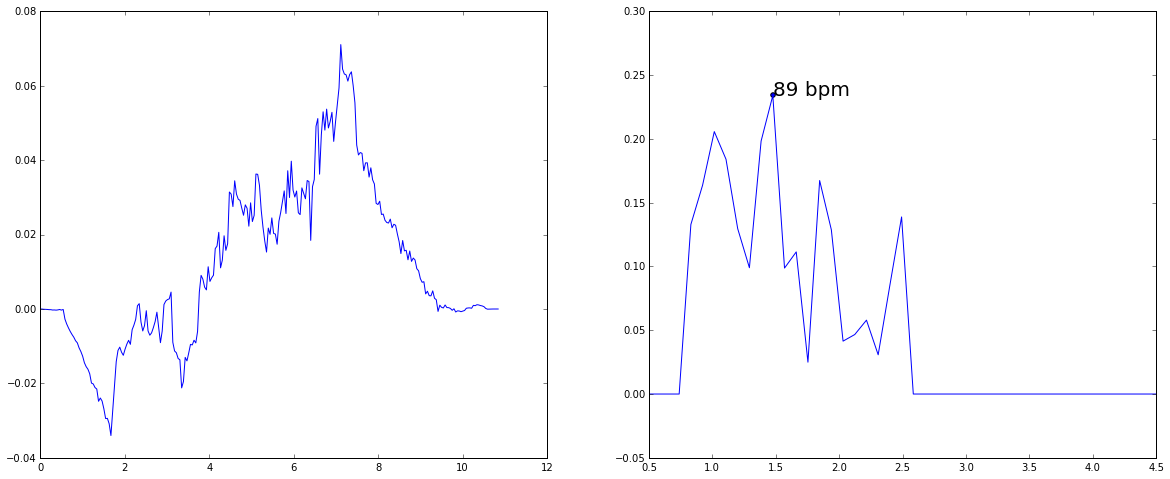

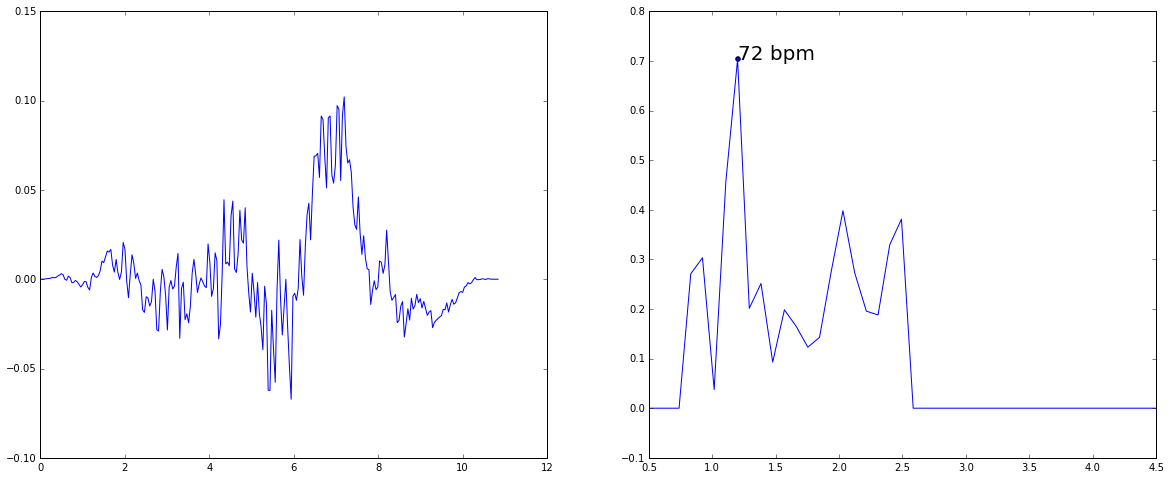

In [8]:
# Independent Component Analysis
from sklearn.decomposition import FastICA

ica = FastICA(n_components=3, max_iter=3000)
comps = ica.fit_transform( np.array([r,g*1.5,b]).T )


for i in range(comps.shape[1]):
    n = len(comps)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    
    comps[:, i] *= np.hanning(comps.shape[0])
    ax1.plot(t, comps[:,i])
    
    #Fourier transform
    I = abs(np.fft.fft(comps[:,i])[:n/2])
    freqs = np.fft.fftfreq(n, 1./FPS)[:n/2]
    
    #Filter
    I[(freqs<.8) | (freqs>2.5)] = 0
    
    max_f = freqs[I.argmax()]
    ax2.scatter(max_f, I.max())
    
    ax2.annotate(s="%.0f bpm"%(max_f*60), xy=(max_f, I.max()), size=20)
    
    ax2.plot(freqs, I)
    ax2.set_xlim(.5, 4.5)
    
    
    plt.show()

In [8]:
len(comps)

1085

In [9]:
import numpy
def acf(series):
    n = len(series)
    data = numpy.asarray(series)
    mean = numpy.mean(data)
    c0 = numpy.sum((data - mean) ** 2) / float(n)
    def r(h):
        acf_lag = ((data[:n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0
        return round(acf_lag, 3)
    x = numpy.arange(n) # Avoiding lag 0 calculation
    acf_coeffs = map(r, x)
    return np.array(acf_coeffs)

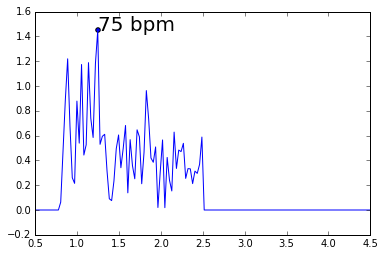

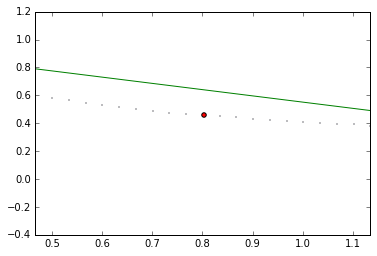

distance: 21


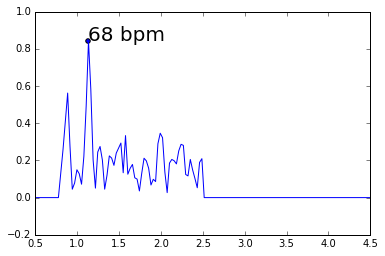

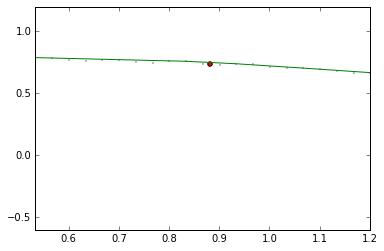

distance: 1


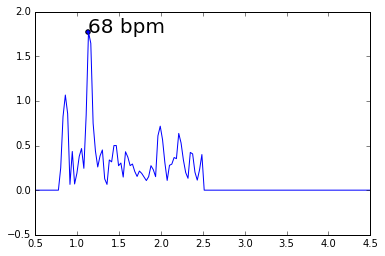

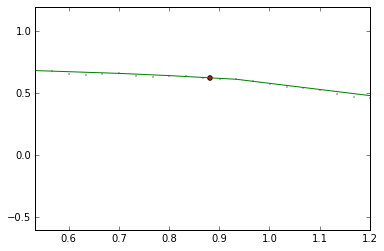

distance: 2
68.0184331797


In [11]:
bpm_guesses = []
for i in range(3):

    comp = comps[:, i]
    
    n = len(comp)
    
    I = abs(np.fft.fft(comp)[:n/2])
    freqs = np.fft.fftfreq(n, 1./FPS)[:n/2]

    #Filter
    I[(freqs<.8) | (freqs>2.5)] = 0

    max_f = freqs[I.argmax()]
    plt.scatter(max_f, I.max())

    plt.annotate(s="%.0f bpm"%(max_f*60), xy=(max_f, I.max()), size=20)

    plt.plot(freqs, I)
    plt.xlim(.5, 4.5)

    plt.show()

    ac = acf(comp)

    window_size = 2
    window = np.ones(int(window_size))/float(window_size)
    ac = np.convolve(ac, window, 'same')

    plt.scatter(t, ac, s=.1)

    indx = abs(t - 1/max_f).argmin()
    y = ac[indx]
    plt.scatter(1./max_f, y, c='r')

    peaks = np.where(numpy.r_[True, ac[1:] > ac[:-1]] & numpy.r_[ac[:-1] > ac[1:], True])[0]
    plt.plot(t[peaks], ac[peaks], c='g')

    plt.xlim(t[indx-10],  t[indx+10])
    plt.show()
    
    bpm_guesses.append((max_f*60,abs(indx - peaks).min()))

    print "distance:", abs(indx - peaks).min()


print min(bpm_guesses, key=lambda x: x[1])[0]

In [30]:
len(x)

3